In [1]:
import cogsworth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u

In [2]:
# this all just makes plots look nice
%config InlineBackend.figure_format = 'retina'

plt.style.use("dark_background")
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
pd.options.display.max_columns = 999

In [3]:
p = cogsworth.pop.Population(100, final_kstar1=[14], timestep_size=0.1 * u.Myr)
p.galactic_potential

<CompositePotential disk,bulge,nucleus,halo>

In [4]:
p.galactic_potential["disk"]

<MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>

In [5]:
p.galactic_potential.circular_velocity(q=[8.5, 0, 0] * u.kpc)

<Quantity [230.74831669] km / s>

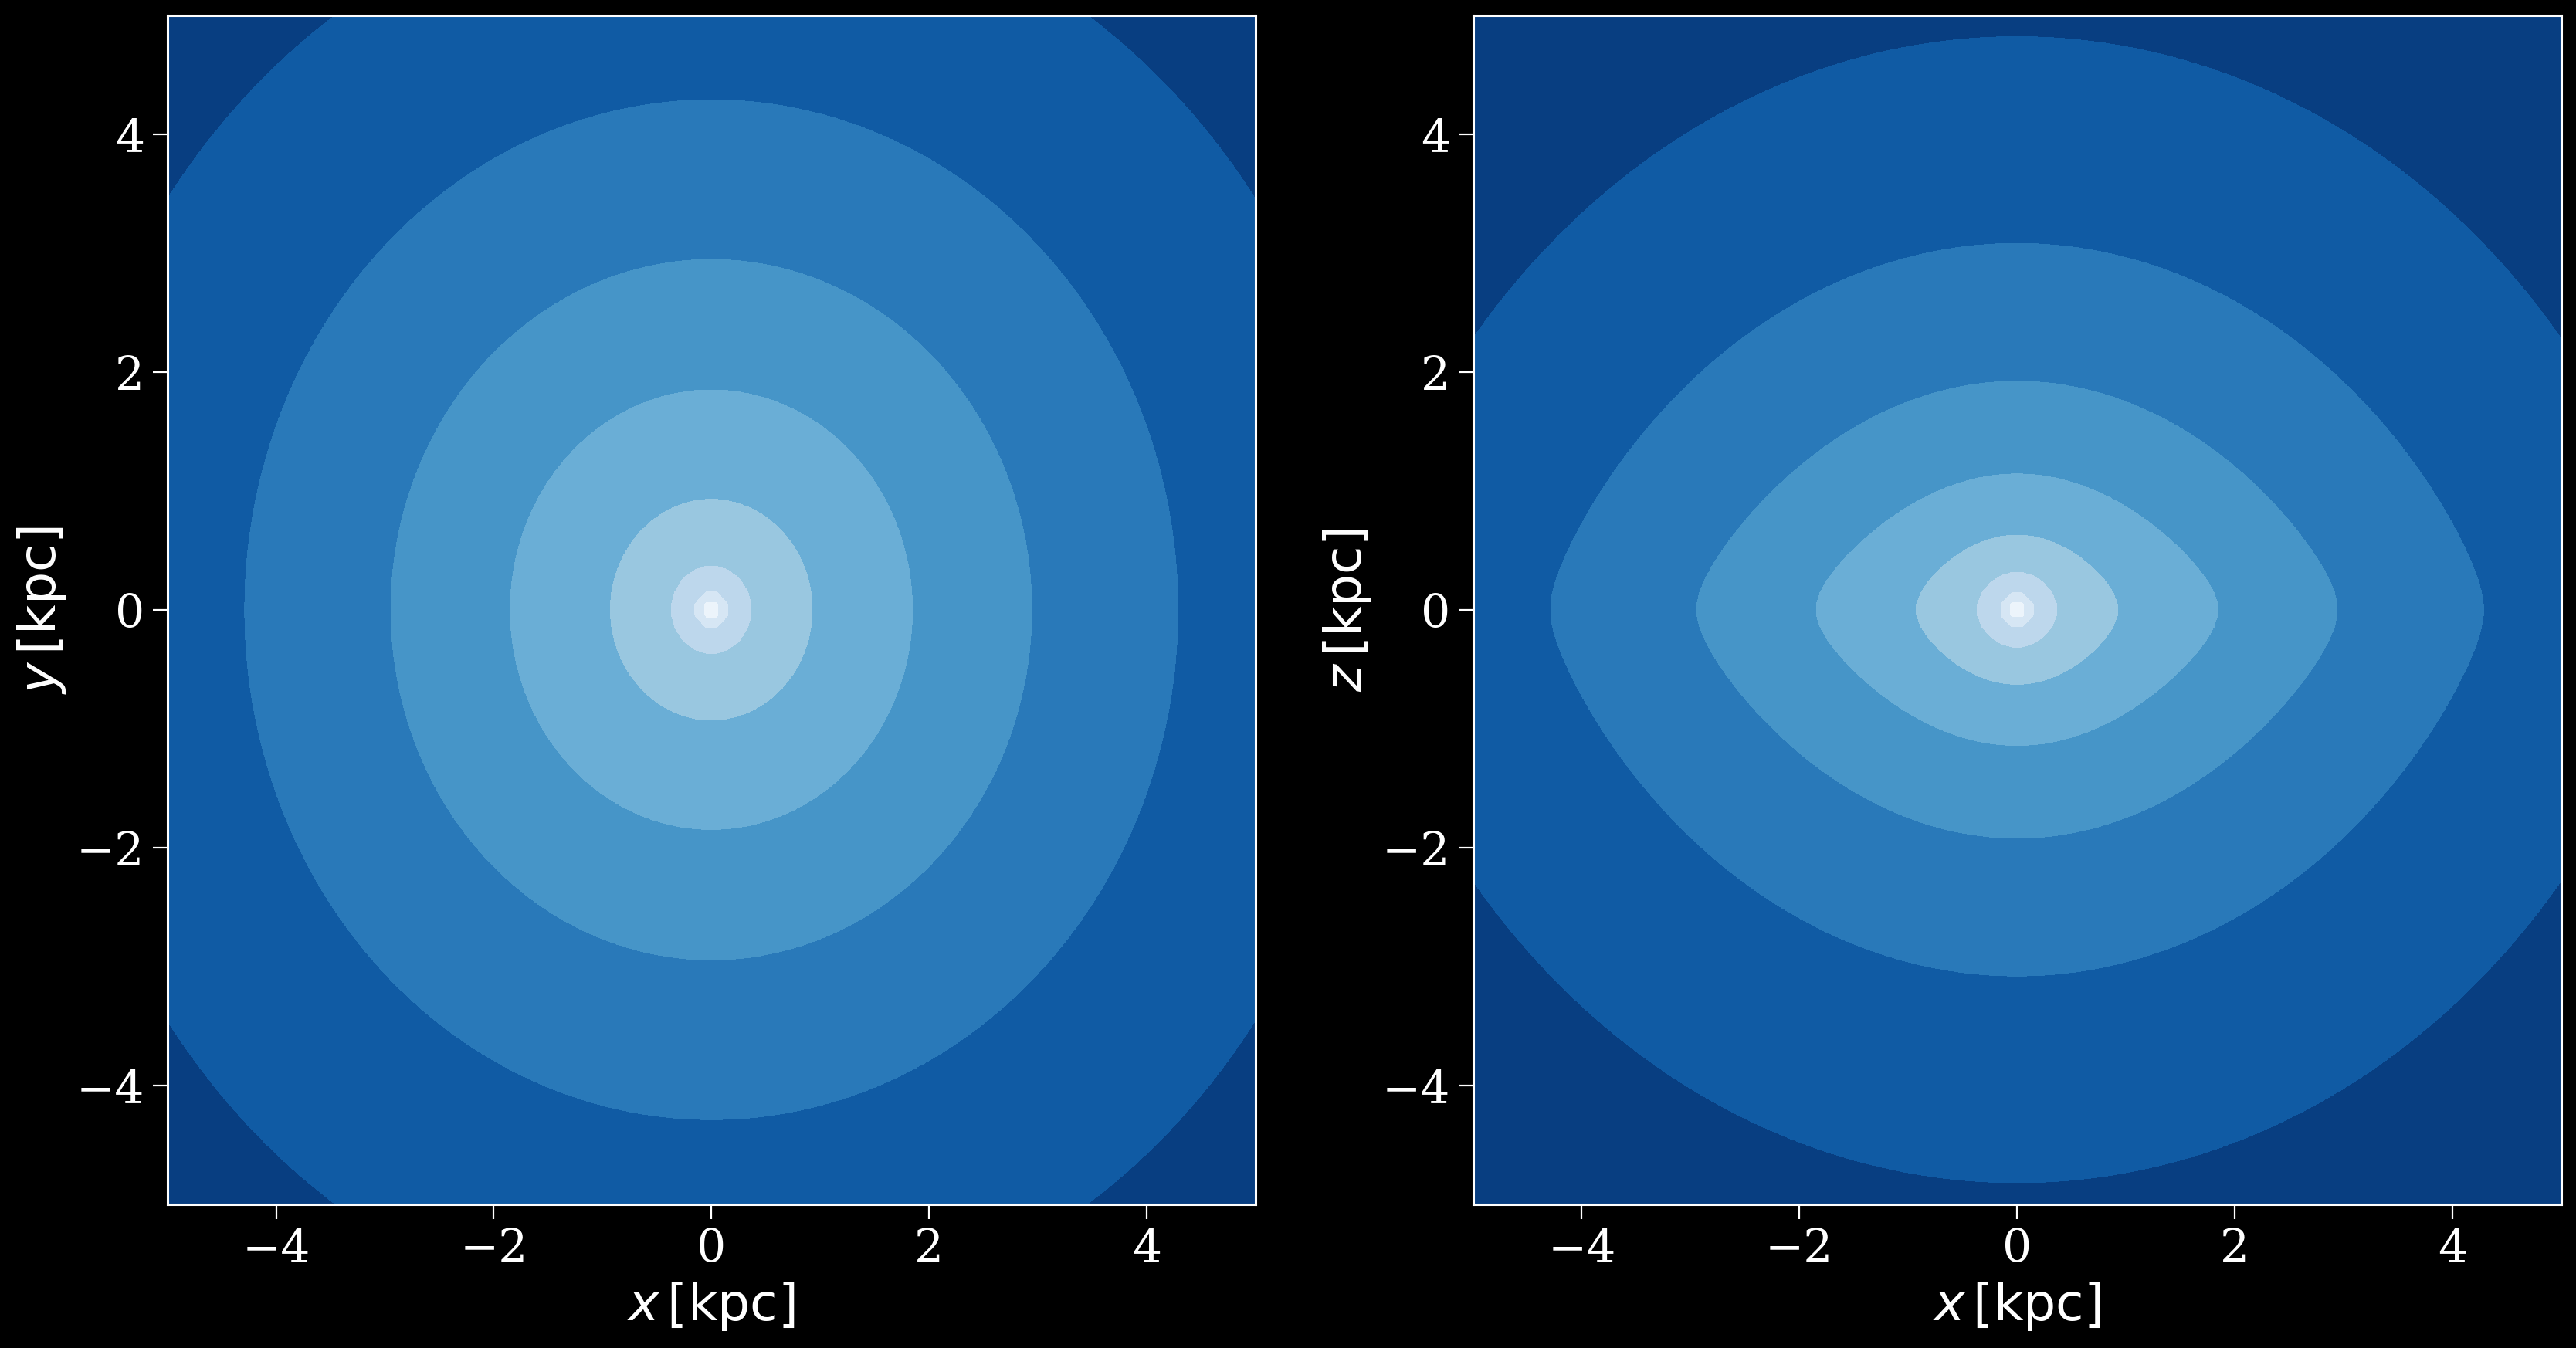

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# define a basic grid to use
grid = np.linspace(-5, 5, 100) * u.kpc

# plot using the grid for x, y, but fixing z=0 kpc (repeat for x-z with y=0)
p.galactic_potential.plot_contours(grid=(grid, grid, 0), ax=axes[0]);
p.galactic_potential.plot_contours(grid=(grid, 0, grid), ax=axes[1]);

axes[0].set(xlabel=r'$x \, [\rm kpc]$', ylabel=r'$y \, [\rm kpc]$')
axes[1].set(xlabel=r'$x \, [\rm kpc]$', ylabel=r'$z \, [\rm kpc]$')

plt.show()

In [7]:
p.create_population(with_timing=False)
p.orbits[0]

<Orbit cartesian, dim=3, shape=(79954,)>

In [8]:
p.orbits[0].pos, p.orbits[0].vel, p.orbits[0].t

(<CartesianRepresentation (x, y, z) in kpc
     [( 2.96543092,  0.43506898,  0.3941708 ),
      ( 2.9621347 ,  0.45781654,  0.39471926),
      ( 2.95868519,  0.4805404 ,  0.39517019), ...,
      (-0.09669216, -0.70558238, -0.5176786 ),
      (-0.0679836 , -0.68211862, -0.51523991),
      (-0.03925489, -0.65845216, -0.51248244)]>,
 <CartesianDifferential (d_x, d_y, d_z) in kpc / Myr
     [(-0.03219499, 0.22759009, 0.00597215),
      (-0.03372897, 0.22735902, 0.00499699),
      (-0.0352609 , 0.22711623, 0.00402148), ...,
      ( 0.28696019, 0.23363185, 0.02281632),
      ( 0.28719908, 0.23564735, 0.02596912),
      ( 0.28736179, 0.2376853 , 0.02919195)]>,
 <Quantity [ 4004.6675397,  4004.7675397,  4004.8675397, ..., 11999.7675397,
            11999.8675397, 11999.9675397] Myr>)

In [9]:
p.orbits[0].z

<Quantity [ 0.3941708 ,  0.39471926,  0.39517019, ..., -0.5176786 ,
           -0.51523991, -0.51248244] kpc>

In [10]:
p.orbits[0].cylindrical.rho

<Quantity [2.99717626, 2.99730512, 2.99745511, ..., 0.71217686, 0.68549805,
           0.65962125] kpc>

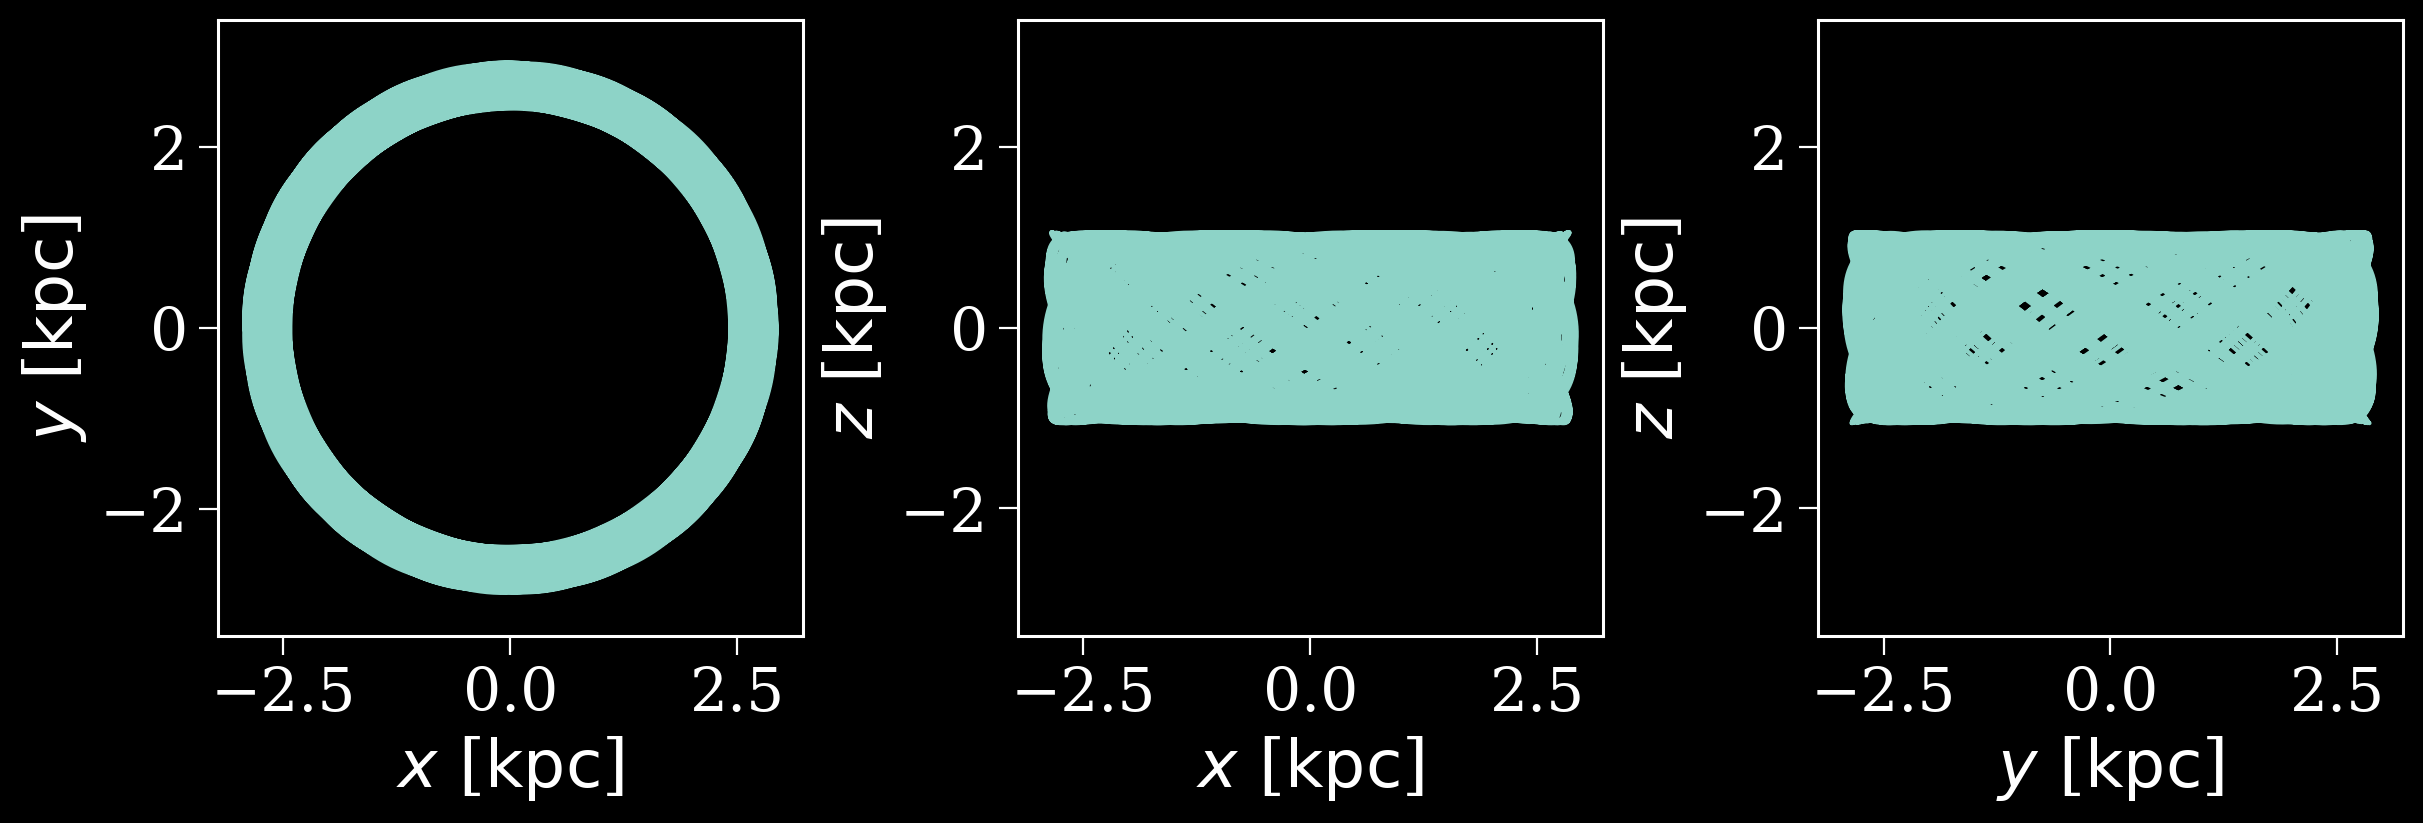

In [11]:
plot_orbit = p.primary_orbits[~p.disrupted & ~p.escaped[:len(p)]][0]
plot_orbit.plot();

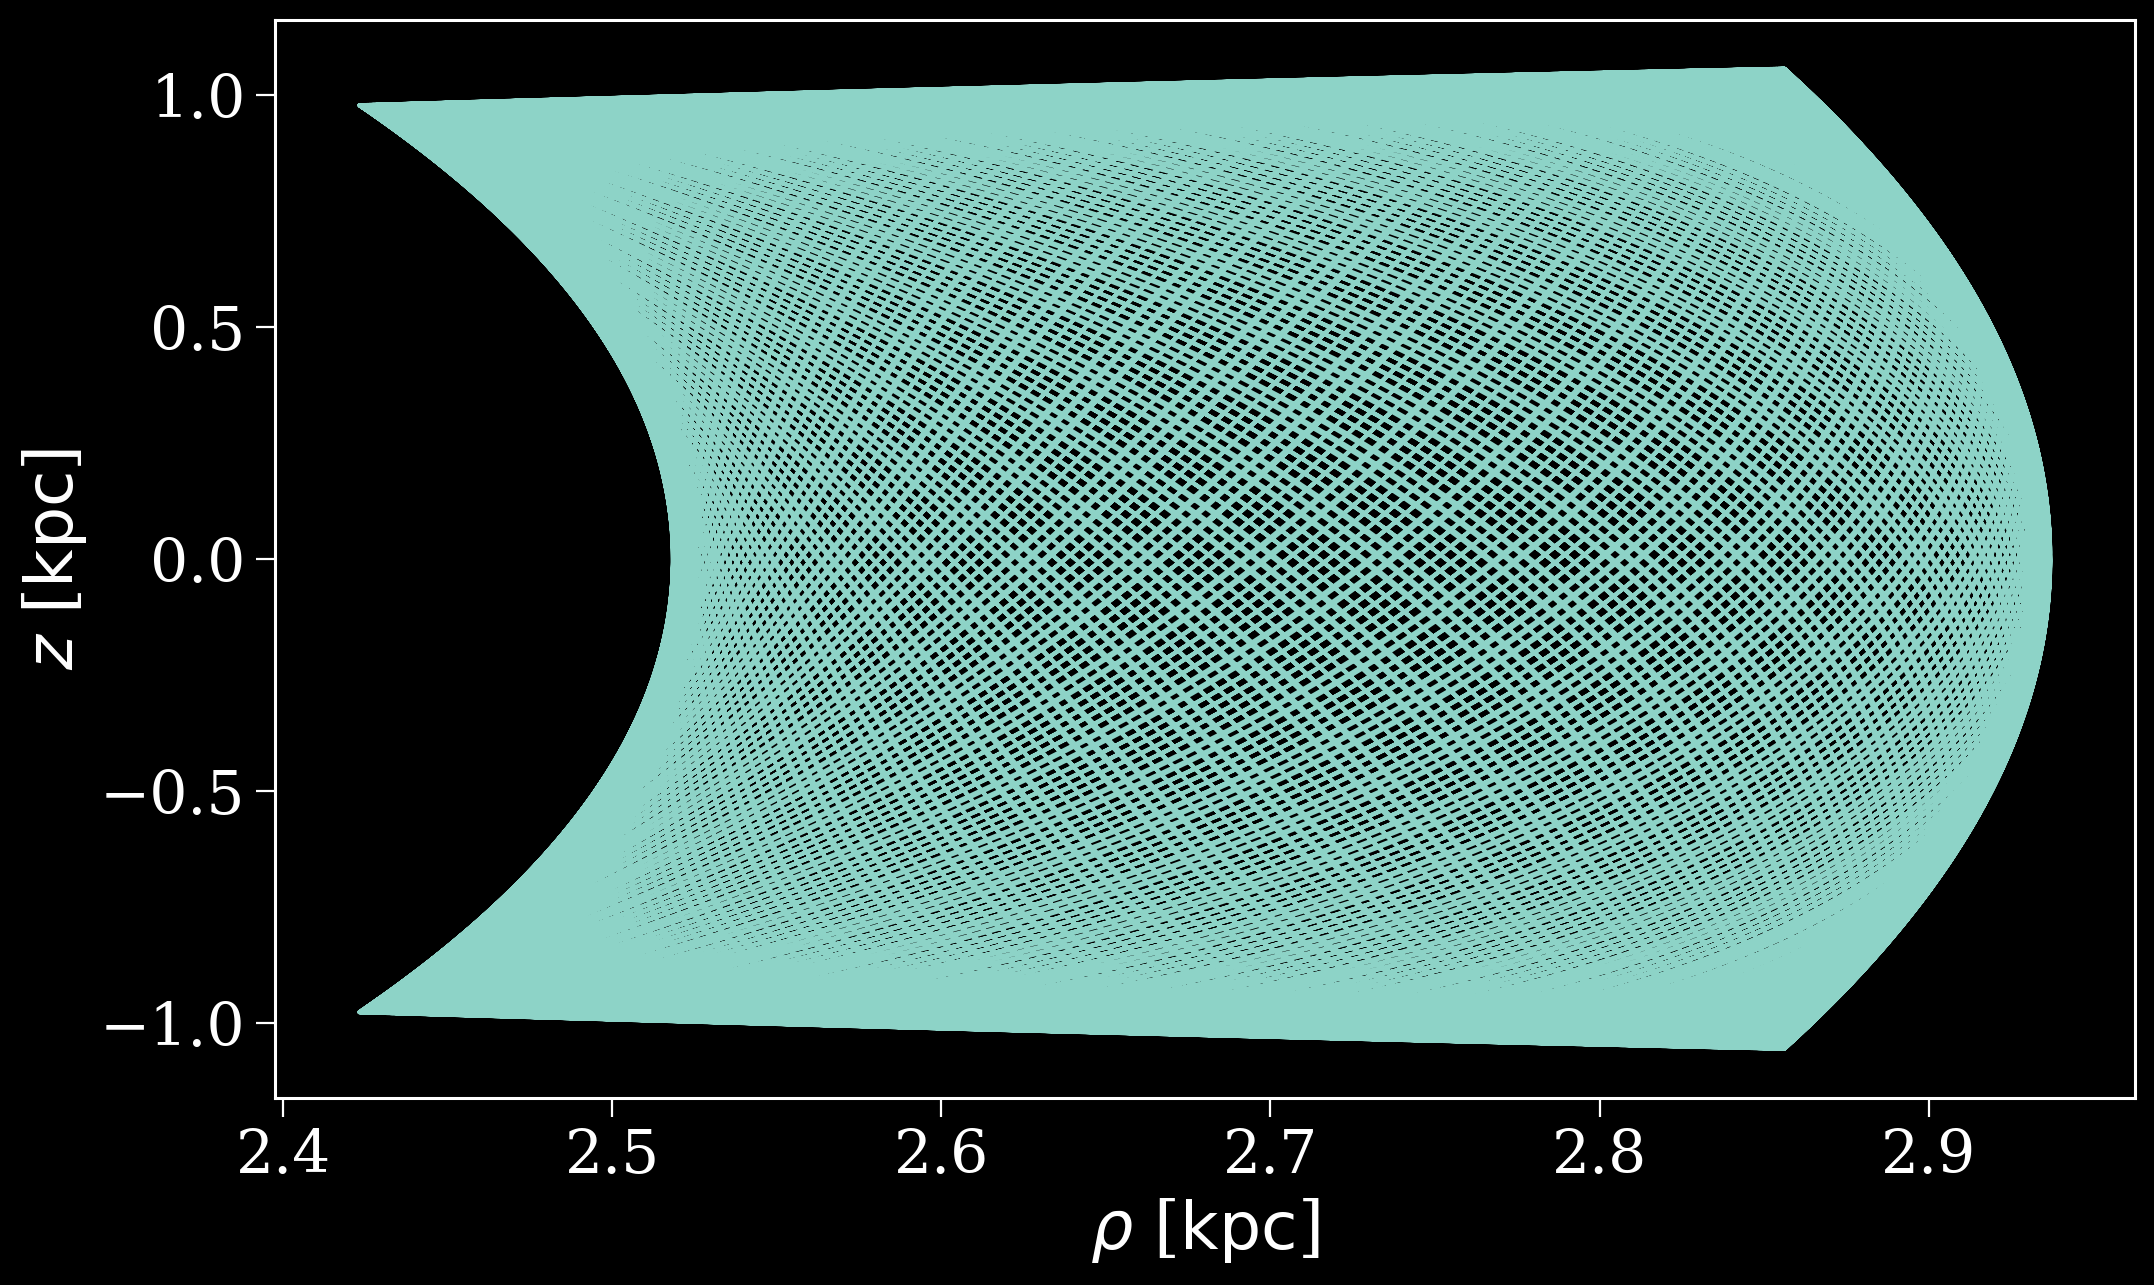

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_orbit.cylindrical.plot(['rho', 'z'], axes=[ax]);

In [13]:
orbit_options_mask = p.disrupted & ~p.escaped[:len(p)]

In [14]:
primary_orbit_options = p.primary_orbits[orbit_options_mask]
secondary_orbit_options = p.secondary_orbits[orbit_options_mask]
target_orbit = None
for i in range(len(primary_orbit_options)):
    if ((primary_orbit_options[i].z.max() > 1 * u.kpc)
        & (primary_orbit_options[i].z.max() < 10 * u.kpc)
        & (secondary_orbit_options[i].z.max() > 1 * u.kpc)
        & (secondary_orbit_options[i].z.max() < 10 * u.kpc)):
        target_ind = i
        break

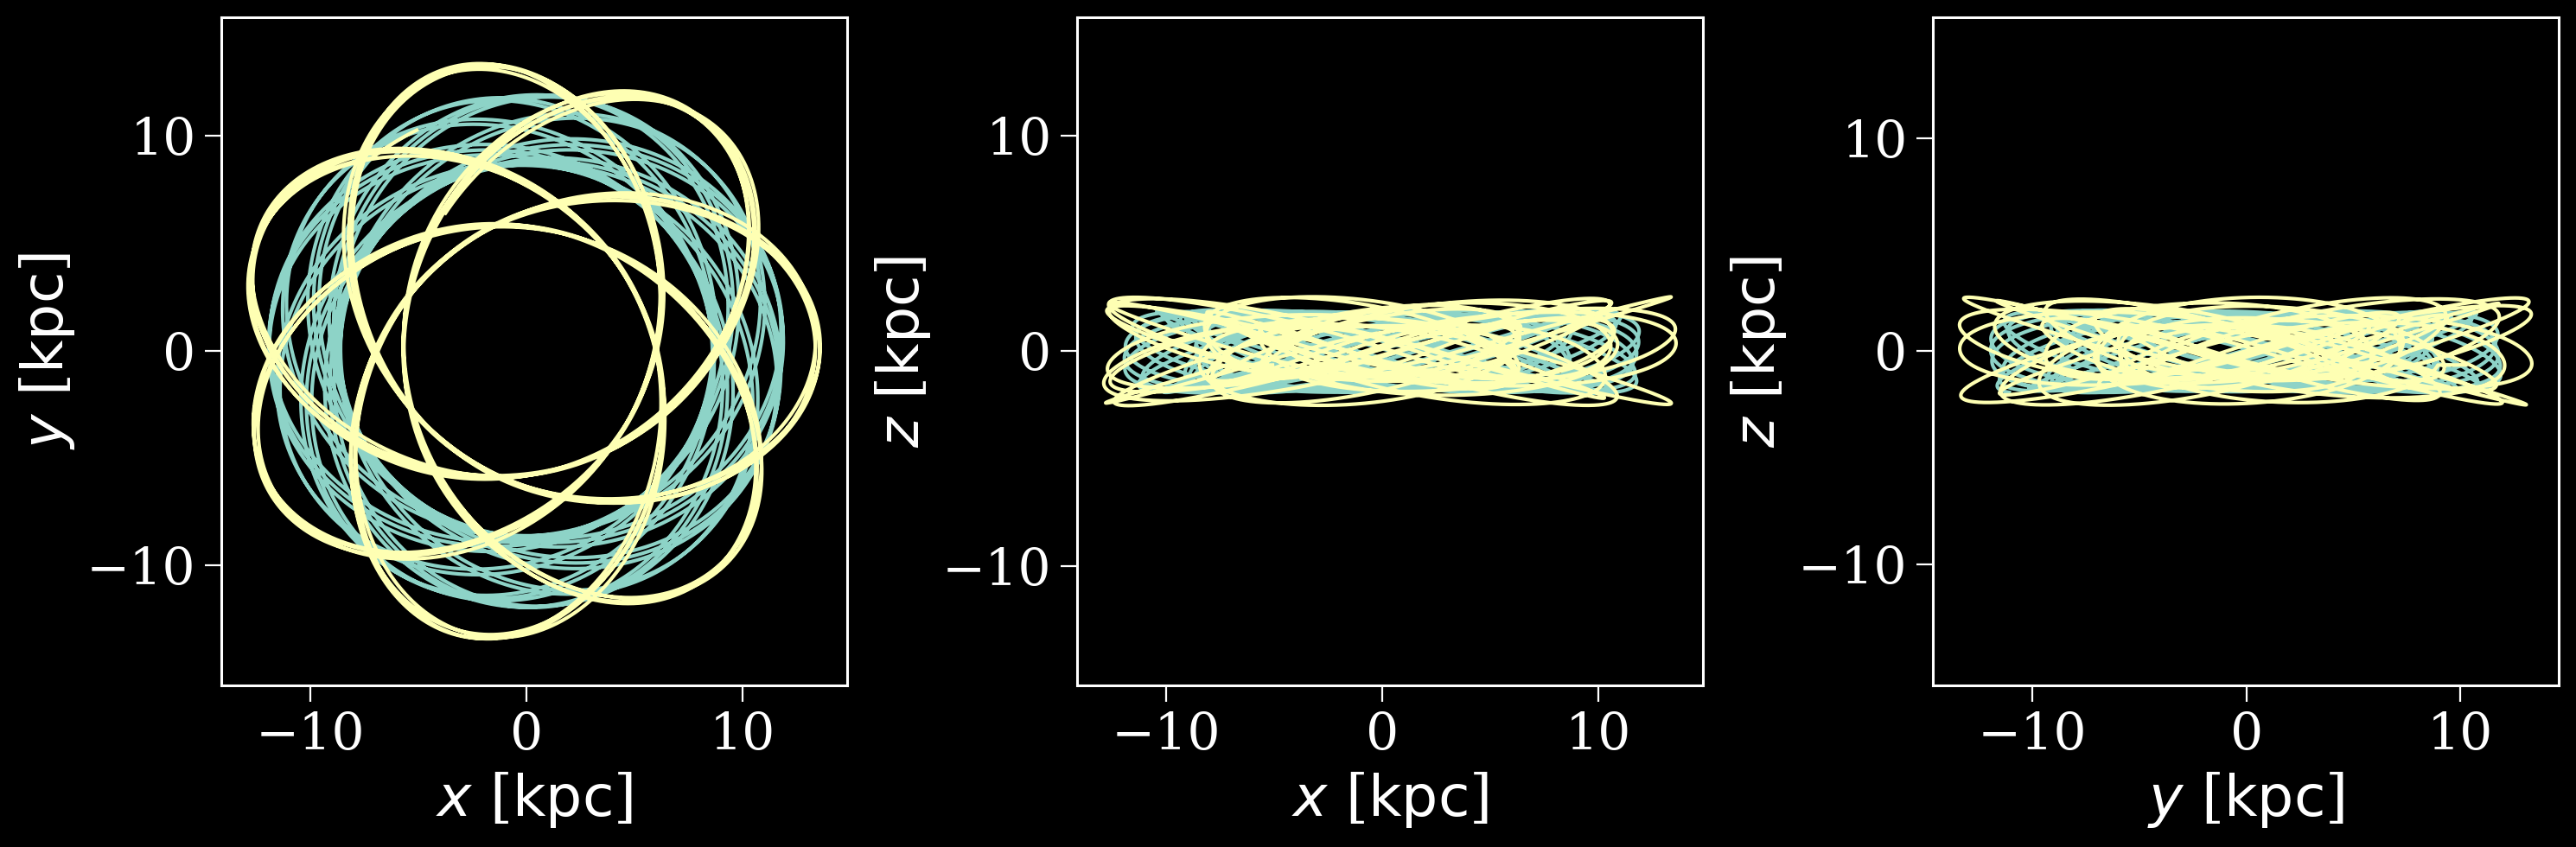

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout="tight")

primary_orbit_options[target_ind].plot(axes=axes);
secondary_orbit_options[target_ind].plot(axes=axes);

In [16]:
target_bpp = p.bpp.loc[p.bin_nums[orbit_options_mask][target_ind]]
disruption_time = target_bpp[target_bpp["evol_type"] == 11]["tphys"].values[0] * u.Myr

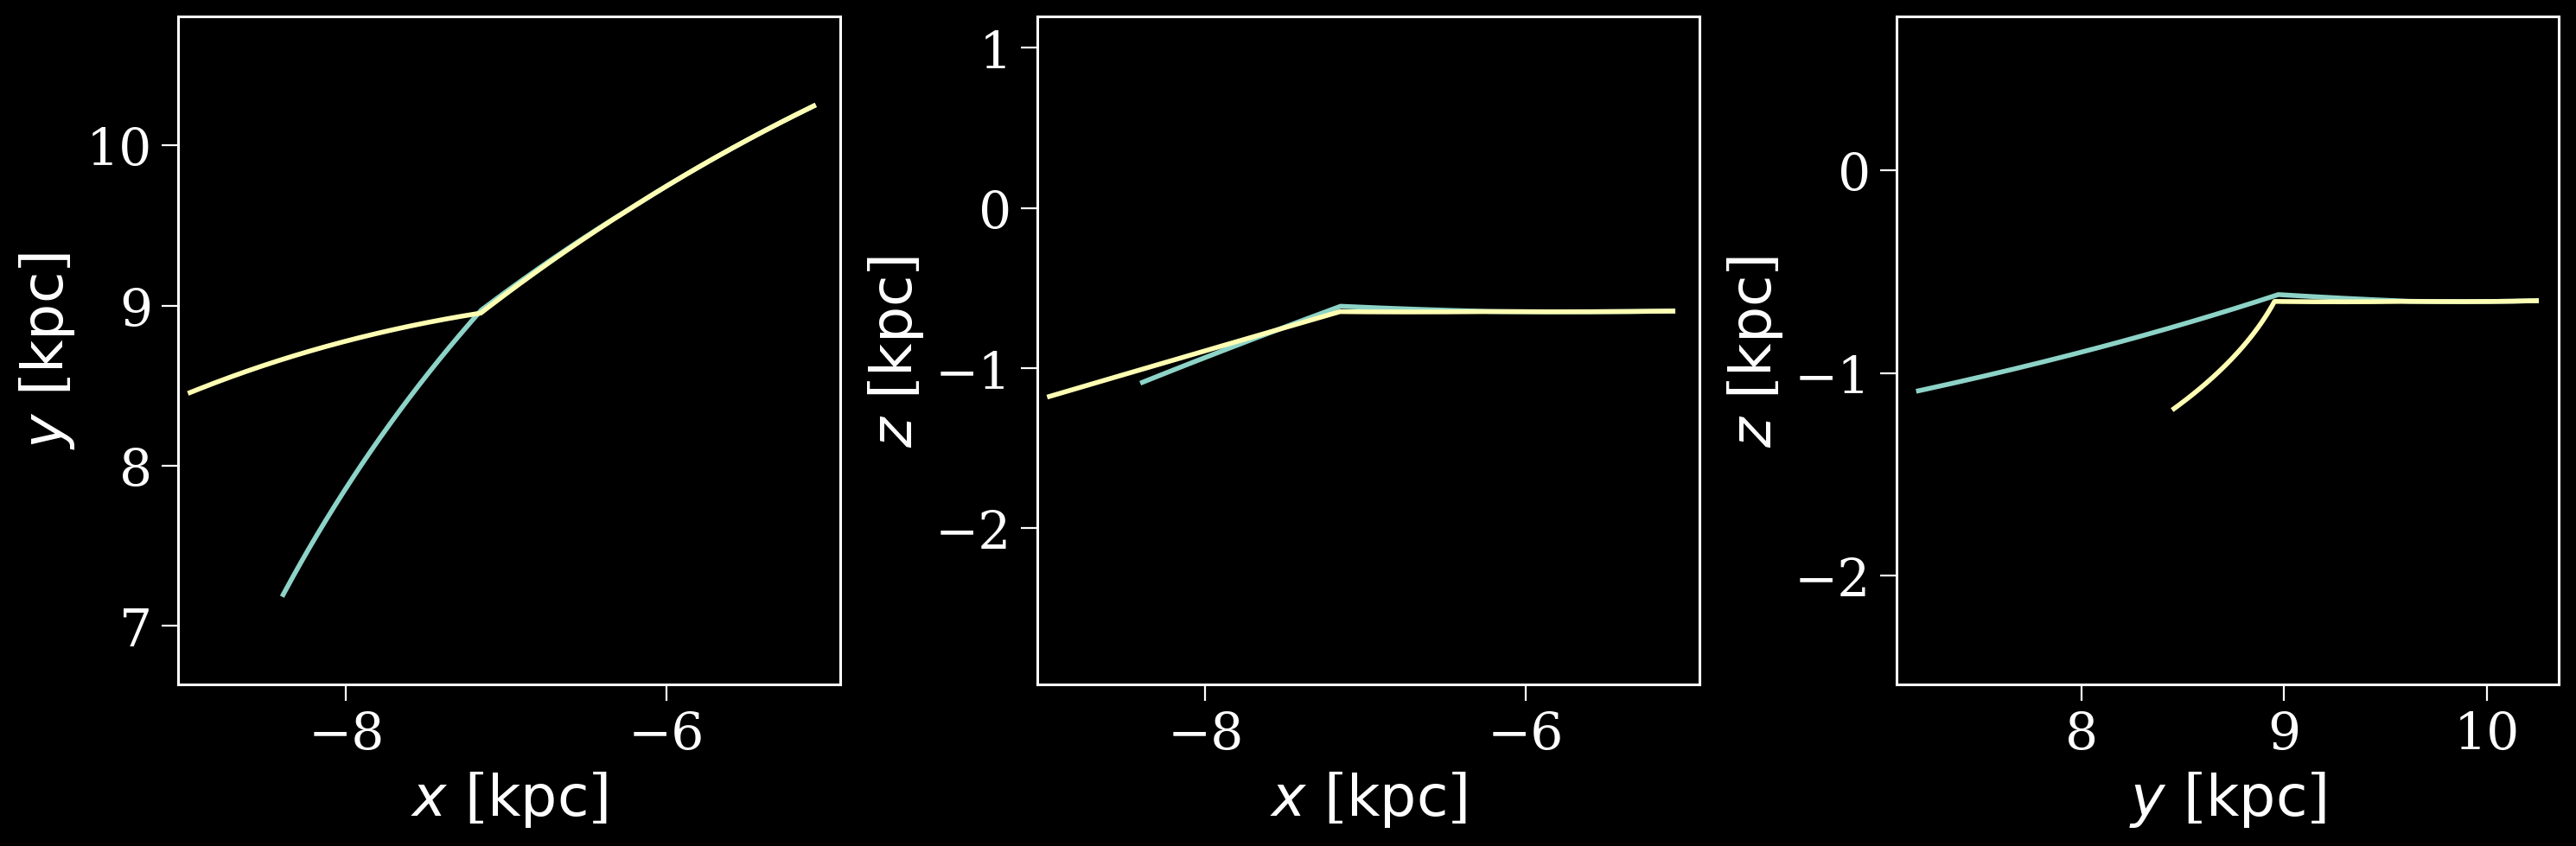

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout="tight")

for orbit in [primary_orbit_options[target_ind],
              secondary_orbit_options[target_ind]]:
    trim_orbit = orbit[(orbit.t - orbit.t[0]) < disruption_time * 2]
    trim_orbit.plot(axes=axes, lw=2);

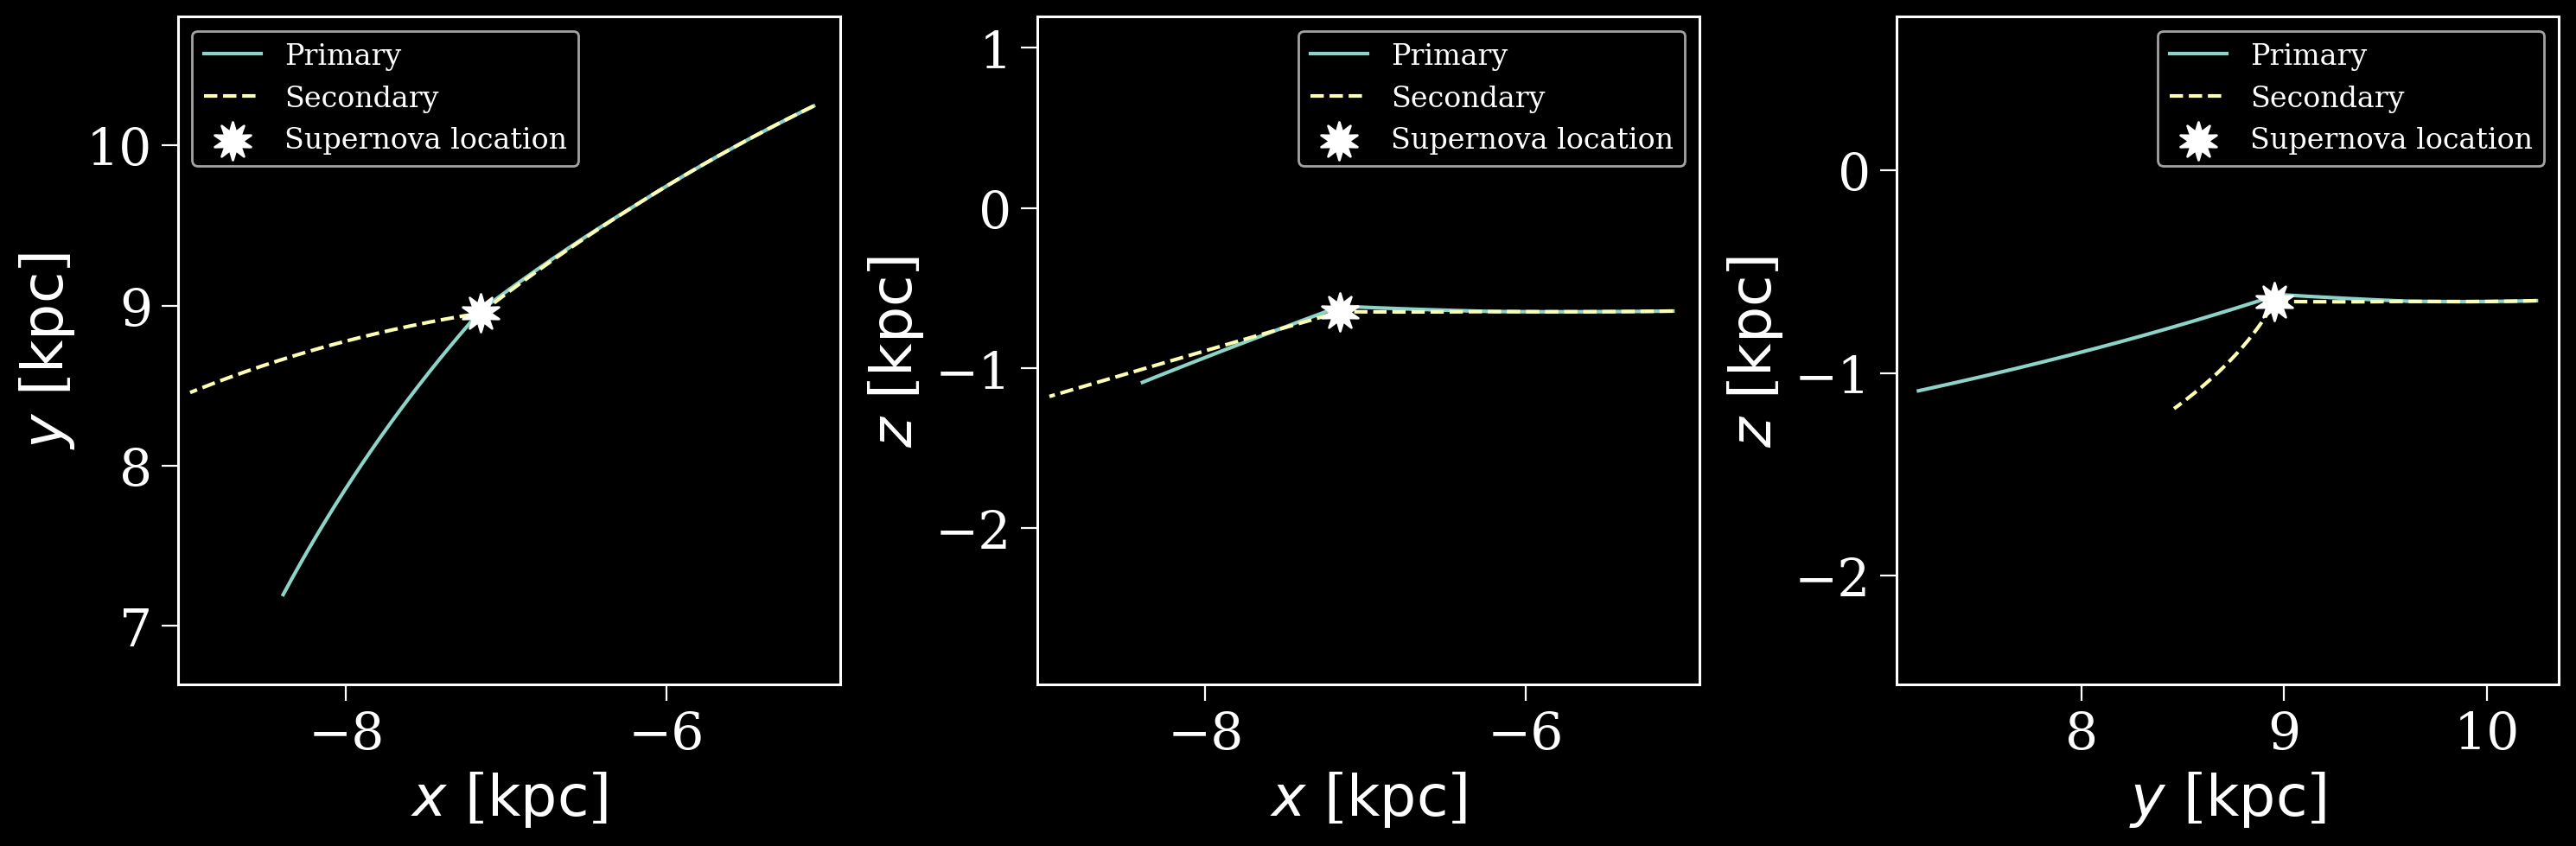

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), layout="tight")

for orbit, label in zip([primary_orbit_options[target_ind],
                         secondary_orbit_options[target_ind]],
                        ["Primary", "Secondary"]):
    ls = "--" if label == "Secondary" else "-"
    trim_orbit = orbit[(orbit.t - orbit.t[0]) < disruption_time * 2]
    trim_orbit.plot(axes=axes, label=label, linestyle=ls);

sn_loc = orbit[np.argmin(np.abs((orbit.t - orbit.t[0]) - disruption_time))]
for ax, x, y in [[axes[0], sn_loc.x, sn_loc.y],
                 [axes[1], sn_loc.x, sn_loc.z],
                 [axes[2], sn_loc.y, sn_loc.z]]:
    ax.scatter(x=x, y=y, s=250, zorder=10, marker=(10, 1, 0), color="white", label="Supernova location")
    
for ax in axes:
    ax.legend(fontsize=0.5*fs)